# Neural Network

In [1]:
import copy
from functools import partial

from astropy import constants as const
import h5py
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
import torch
from torch.nn import Dropout, Linear, Sequential, ReLU, MaxPool1d, Conv1d, Flatten, MSELoss, Module
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

In [2]:
LOGLAMMIN, LOGLAMMAX = 3.5836, 3.9559
WAVES = np.logspace(LOGLAMMIN, LOGLAMMAX, num=512)
spectral_lines = {
    "Lyalpha": 1216,
    "C IV": 1549,
    "C III": 1909,
    "Mg II": 2796,
    "Hbeta": 4862,
    "Halpha": 6563}
DEVICE = torch.device("cuda")

## Data

In [3]:
datafile = h5py.File("data/dataset.hdf5", mode='r')
datafile.keys()

<KeysViewHDF5 ['X', 'X_te', 'X_tr', 'X_va', 'flux', 'id', 'id_te', 'id_tr', 'id_va', 'z', 'z_te', 'z_tr', 'z_va']>

In [4]:
X = torch.from_numpy(datafile["X_tr"][:])
X_va = torch.from_numpy(datafile["X_va"][:])
X.shape, X.dtype, X_va.shape, X_va.dtype

(torch.Size([440007, 512]),
 torch.float32,
 torch.Size([50000, 512]),
 torch.float32)

In [5]:
y = torch.from_numpy(datafile["z_tr"][:]).unsqueeze(dim=1).float()
y_va = torch.from_numpy(datafile["z_va"][:]).unsqueeze(dim=1).float()
y.shape, y.dtype, y_va.shape, y_va.dtype

(torch.Size([440007, 1]), torch.float32, torch.Size([50000, 1]), torch.float32)

Text(0.5, 0, 'z')

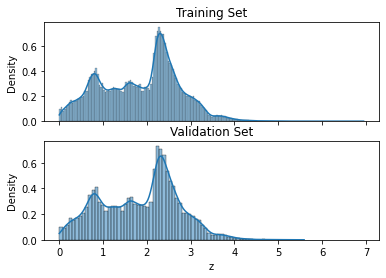

In [6]:
def plot_z_displot(z_first, z_second):
    fig, axs = plt.subplots(nrows=2, sharex=True)
    for ax, z in zip(axs, (z_first, z_second)):
        sns.histplot(
            z.squeeze().numpy(), ax=ax,
            kde=True, stat="density")
    return fig, axs

fig, axs = plot_z_displot(y, y_va)
axs[0].set_title("Training Set")
axs[1].set_title("Validation Set")
axs[1].set_xlabel("z")

<AxesSubplot:title={'center':'z_true = 1.5150'}, xlabel='wave', ylabel='flux'>

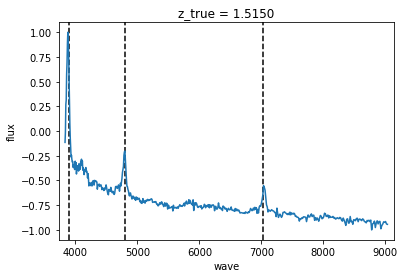

In [7]:
def plot_redshift(ax, z, z_std=None, color="k"):
    for line in spectral_lines.values():
        ax.axvline((1 + z) * line, color=color, linestyle="--")
        if z_std is not None:
            ax.fill_betweenx(
                [-1, 1],
                (1 + (z - 1.96 * z_std)) * line,
                (1 + (z + 1.96 * z_std)) * line,
                color=color, alpha=0.2)
    return ax

def plot_spec(flux, z_true, z_pred=None, z_std=None):
    ax = plt.axes(
        xlabel="wave", ylabel="flux",
        xlim=(10 ** LOGLAMMIN - 100, 10 ** LOGLAMMAX + 100))
    title = "z_true = {:.4f}".format(z_true)
    plot_redshift(ax, z_true)
    if z_pred is not None:
        title += ", z_pred = {:.4f}".format(z_pred)
        if z_std is not None:
            title += ", z_std = {:.4f}".format(z_std)
        plot_redshift(ax, z_pred, z_std, color="r")
    ax.plot(WAVES, flux)
    ax.set_title(title)
    return ax

rnd_idx = np.random.randint(X.shape[0])
plot_spec(X[rnd_idx], y[rnd_idx, 0])

## Fully Connected Neural Network

In [8]:
input_dim = X.shape[1]
input_dim

512

### Early Stopping

BISHOP, Christopher M. *Pattern Recognition and Machine Learning*. New York: Springer, 2006. ISBN 978-0-387-31073-2.


The error measured with respect to independet data, generally called a validation set, often shows a decrease at first, followed by an increase as the network starts to over-fit. Training can therefore be stopped at the point of smallest error with respect to the validation data set in order to obtain a network having good generalization performance.

Halting training before a minimum of the training error has been reached then represents a way of limiting the effective network complexity.

In [9]:
def predict(model, X):
    ds = TensorDataset(X)
    dl = DataLoader(ds, batch_size=1024, shuffle=False)
    with torch.no_grad():
        return torch.cat([model(xb.to(DEVICE)).cpu() for [xb] in dl])

def train(model, X, y, X_va, y_va, patience, criterion=MSELoss(), weight_decay=1e-3):
    optimizer = torch.optim.Adam(model.parameters(), weight_decay)
    ds = TensorDataset(X, y)
    dl = DataLoader(ds, batch_size=128, shuffle=True)
    losses, losses_va = [], []

    epoch = 0
    best_loss = float("inf")
    no_improvement = 0
    while no_improvement < patience:
        model.train()
        for xb, yb in dl:
            optimizer.zero_grad()
            loss = criterion(model(xb.to(DEVICE)), yb.to(DEVICE))
            loss.backward()
            optimizer.step()

        model.eval()
        losses.append(criterion(predict(model, X), y).item())
        losses_va.append(criterion(predict(model, X_va), y_va).item())
        if losses_va[-1] < best_loss:
            best_loss = losses_va[-1]
            best_model = copy.deepcopy(model)
            no_improvement = 0
        else:
            no_improvement += 1
        
        epoch += 1
        print("{}. epoch: {} ({})".format(epoch, losses_va[-1], best_loss))

    return best_model, losses, losses_va

In [10]:
nn = Sequential(
    Linear(input_dim, 256, bias=True),
    ReLU(),
    Dropout(0.5),
    Linear(256, 128, bias=True),
    ReLU(),
    Dropout(0.5),
    Linear(128, 1, bias=True)
).to(DEVICE)

patience = 16
nn, losses, losses_va = train(nn, X, y, X_va, y_va, patience)

# get number of parameters
sum(p.numel() for p in nn.parameters() if p.requires_grad)

1. epoch: 0.16862668097019196 (0.16862668097019196)
2. epoch: 0.13442979753017426 (0.13442979753017426)
3. epoch: 0.14079385995864868 (0.13442979753017426)
4. epoch: 0.11621777713298798 (0.11621777713298798)
5. epoch: 0.1097220927476883 (0.1097220927476883)
6. epoch: 0.11188488453626633 (0.1097220927476883)
7. epoch: 0.09744774550199509 (0.09744774550199509)
8. epoch: 0.09028438478708267 (0.09028438478708267)
9. epoch: 0.09843351691961288 (0.09028438478708267)
10. epoch: 0.08664197474718094 (0.08664197474718094)
11. epoch: 0.1636648327112198 (0.08664197474718094)
12. epoch: 0.0831465795636177 (0.0831465795636177)
13. epoch: 0.09243874251842499 (0.0831465795636177)
14. epoch: 0.06827034056186676 (0.06827034056186676)
15. epoch: 0.07737971842288971 (0.06827034056186676)
16. epoch: 0.08271953463554382 (0.06827034056186676)
17. epoch: 0.07792302966117859 (0.06827034056186676)
18. epoch: 0.07432815432548523 (0.06827034056186676)
19. epoch: 0.07816766947507858 (0.06827034056186676)
20. epoch

164353

(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:xlabel='epoch', ylabel='MSEloss'>)

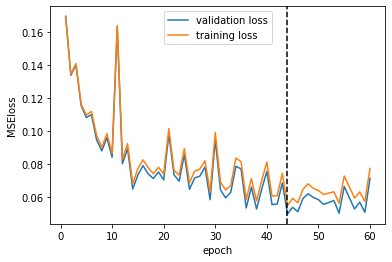

In [11]:
def plot_losses(losses, losses_va):
    fig, ax = plt.subplots()
    ax.set_xlabel("epoch")
    ax.set_ylabel("MSEloss")
    epochs = len(losses)
    ax.plot(np.arange(1, epochs + 1), losses, label="validation loss")
    ax.plot(np.arange(1, epochs + 1), losses_va, label="training loss")
    ax.axvline(np.argmin(losses_va) + 1, color="k", linestyle="--")
    ax.legend()
    return fig, ax

plot_losses(losses, losses_va)

In [12]:
nn.eval()
nn_y_pred = predict(nn, X_va)

Text(0.5, 1.0, 'Predictions')

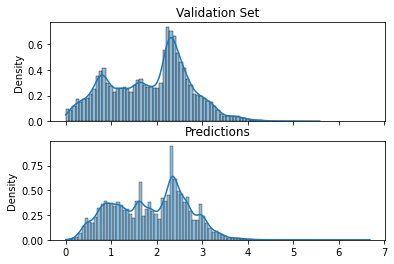

In [13]:
fig, axs = plot_z_displot(y_va, nn_y_pred)
axs[0].set_title("Validation Set")
axs[1].set_title("Predictions")

<AxesSubplot:title={'center':'z_true = 1.6320, z_pred = 1.3757'}, xlabel='wave', ylabel='flux'>

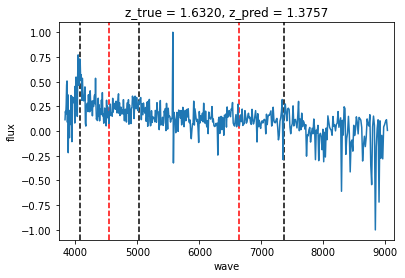

In [14]:
rnd_idx = np.random.randint(X_va.shape[0])
plot_spec(X_va[rnd_idx], y_va[rnd_idx, 0], nn_y_pred[rnd_idx, 0])

In [15]:
rmse = partial(mean_squared_error, squared=False)
rmse(y_va, nn_y_pred)

0.23479742

$\Delta v = c \frac{z - z_\mathrm{VI}}{1 + z_\mathrm{VI}}$

In [16]:
# speed of light in vacuum (unit km / s)
c = const.c.to("km / s").value

def delta_v(y_va, y_pred):
    return c * (torch.abs(y_pred - y_va) / (1 + y_va))

def catastrophic_redshift_ratio(y_va, y_pred):
    nn_delta_v = delta_v(y_va, y_pred)
    ratio = torch.sum(nn_delta_v > 3000) / nn_delta_v.size(0)
    return ratio.item()

catastrophic_redshift_ratio(y_va, nn_y_pred)

0.6759399771690369

## Bayesian Neural Network

In [17]:
# TODO see 5.7. Bayesian Neural Networks in Bishop: Pattern Recognition and Machine Learning

## Bayesian Deep Learning

- [Uncertainty in Deep Learning](http://www.cs.ox.ac.uk/people/yarin.gal/website/blog_2248.html)
- [Bayesian Deep Learning 101](http://www.cs.ox.ac.uk/people/yarin.gal/website/bdl101/)
- [MLSS 2019 Skoltech Tutorials](https://github.com/mlss-skoltech/tutorials)

### Approximate Inference in Bayesian Neural Network with Dropout

"Drawing a new function for each test point makes no difference if all we care about is obtaining the predictive mean and predictive variance (actually, for these two quantities this process is preferable to the one I will describe below), but this process does not result in draws from the induced distribution over functions." ([Uncertainty in Deep Learning](http://www.cs.ox.ac.uk/people/yarin.gal/website/blog_2248.html))

In [18]:
bnn = nn

In [19]:
def point_estimate(model, X, samples):
    model.train()
    outputs = torch.zeros(samples, X.size(0), 1)
    for i in range(samples):
        outputs[i] = predict(model, X)
    return outputs

samples = point_estimate(bnn, X_va, samples=128)
samples.size()

torch.Size([128, 50000, 1])

In [20]:
bnn_mean, bnn_std = samples.mean(dim=0), samples.std(dim=0)

In [21]:
rmse(bnn_mean, y_va), catastrophic_redshift_ratio(bnn_mean, y_va)

(0.23096612, 0.7465000152587891)

<AxesSubplot:title={'center':'z_true = 2.6290, z_pred = 2.6528, z_std = 0.1307'}, xlabel='wave', ylabel='flux'>

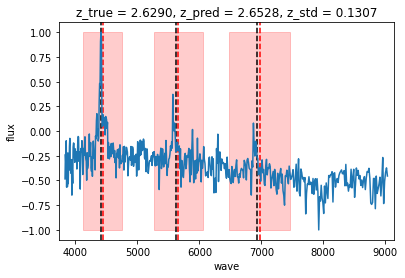

In [22]:
rnd_idx = np.random.randint(X_va.size(0))
plot_spec(X_va[rnd_idx], y_va[rnd_idx, 0], bnn_mean[rnd_idx, 0], bnn_std[rnd_idx, 0])

(<Figure size 432x288 with 2 Axes>,
 array([<AxesSubplot:ylabel='Density'>, <AxesSubplot:ylabel='Density'>],
       dtype=object))

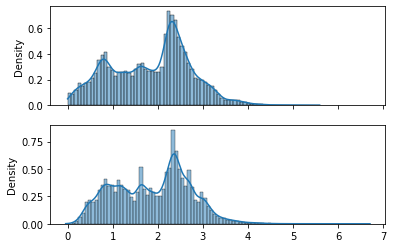

In [23]:
plot_z_displot(y_va, bnn_mean)

<AxesSubplot:xlabel='std(z)', ylabel='Count'>

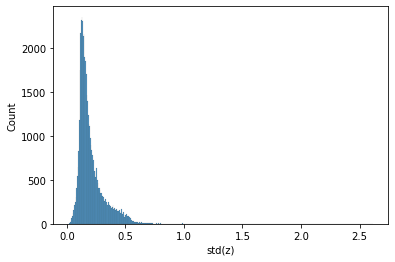

In [24]:
ax = plt.axes(xlabel="std(z)")
sns.histplot(bnn_std.squeeze().numpy(), ax=ax)

2.6153268814086914


<AxesSubplot:title={'center':'z_true = 5.0620, z_pred = 6.5781, z_std = 2.6153'}, xlabel='wave', ylabel='flux'>

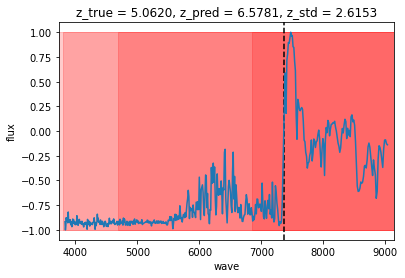

In [25]:
idx = bnn_std.argmax()
print(bnn_std.max().item())
plot_spec(X_va[idx], y_va[idx, 0], bnn_mean[idx, 0], bnn_std[idx, 0])

0.0160466767847538


<AxesSubplot:title={'center':'z_true = 1.6290, z_pred = 1.6150, z_std = 0.0160'}, xlabel='wave', ylabel='flux'>

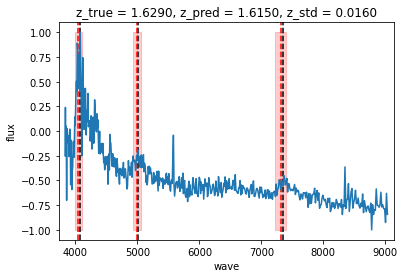

In [26]:
idx = bnn_std.argmin()
print(bnn_std.min().item())
plot_spec(X_va[idx], y_va[idx, 0], bnn_mean[idx, 0], bnn_std[idx, 0])

Text(0.5, 0, 'std')

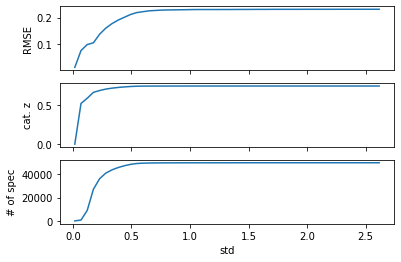

In [63]:
eps = 0.0001
std_range = np.linspace(bnn_std.min().item() + eps, bnn_std.max().item())

fig, axs = plt.subplots(nrows=3, sharex=True)
axs[0].plot(
    std_range,
    [rmse(bnn_mean[bnn_std < std], y_va[bnn_std < std]) for std in std_range])
axs[0].set_ylabel("RMSE")
axs[1].plot(
    std_range,
    [catastrophic_redshift_ratio(bnn_mean[bnn_std < std], y_va[bnn_std < std])
     for std in std_range])
axs[1].set_ylabel("cat. z")
axs[2].plot(
    std_range,
    [(bnn_std < std).sum() for std in std_range])
axs[2].set_ylabel("# of spec")
axs[2].set_xlabel("std")